# 모듈 임포트하기

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras.utils import plot_model
from IPython import display

# 데이터 불러오기

In [ ]:
# mnist 데이터세트를 불러옵니다.
(train_images_origin, train_labels_origin), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
# 레이블만 불러올수 있는 코드를 작성합니다.
def extract_data_by_labels(target_labels):
    # MNIST 데이터를 불러옵니다.
    (train_images_origin, train_labels_origin), _ = tf.keras.datasets.mnist.load_data()

    # 주어진 레이블(target_labels)에 해당하는 인덱스를 추출합니다.
    target_indices = np.isin(train_labels_origin, target_labels)

    # 해당 인덱스를 사용하여 이미지와 레이블을 추출합니다.
    train_images = train_images_origin[target_indices]
    train_labels = train_labels_origin[target_indices]

    return train_images, train_labels

# 사용 예:
target_labels = [1, 2, 3,4,5,6,7,8,9,0]
train_images, train_labels = extract_data_by_labels(target_labels)
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [ ]:
BUFFER_SIZE = 60000 # 버퍼의 사이즈를 정합니다.
BATCH_SIZE = 256 # 학습에 사용될 배치 사이즈를 조정합니다.

In [ ]:
# 한 에포크당 사용될 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

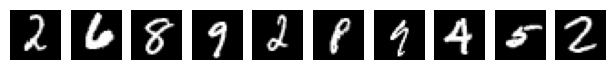

In [ ]:
# 첫 번째 배치 데이터를 가져옵니다.
for images in train_dataset.take(1):
    batch_size = images.shape[0]

    # 각 이미지를 시각화합니다.
    plt.figure(figsize=(200, 200))
    for i in range(10):
        ax = plt.subplot(1, batch_size, i + 1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()


# 생성자 정의

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()  # Sequential 모델 시작

    # 100차원의 노이즈를 입력으로 받아, 7x7x256 크기의 텐서로 변환
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())  # 배치 정규화를 통해 학습을 안정화
    model.add(layers.LeakyReLU())  # Leaky ReLU 활성화 함수

    # 7x7x256 크기의 텐서로 차원을 변경 (reshape)
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # 출력 크기 확인

    # 컨볼루션 레이어: 7x7x256에서 7x7x128 크기로 변환
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  # 출력 크기 확인
    model.add(layers.BatchNormalization())  # 배치 정규화
    model.add(layers.LeakyReLU())  # Leaky ReLU 활성화 함수

    # 컨볼루션 레이어: 7x7x128에서 14x14x64 크기로 변환
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)  # 출력 크기 확인
    model.add(layers.BatchNormalization())  # 배치 정규화
    model.add(layers.LeakyReLU())  # Leaky ReLU 활성화 함수

    # 최종 컨볼루션 레이어: 14x14x64에서 28x28x1 크기의 이미지로 변환 (tanh 활성화함수 사용)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)  # 출력 크기 확인

    return model  # 모델 반환


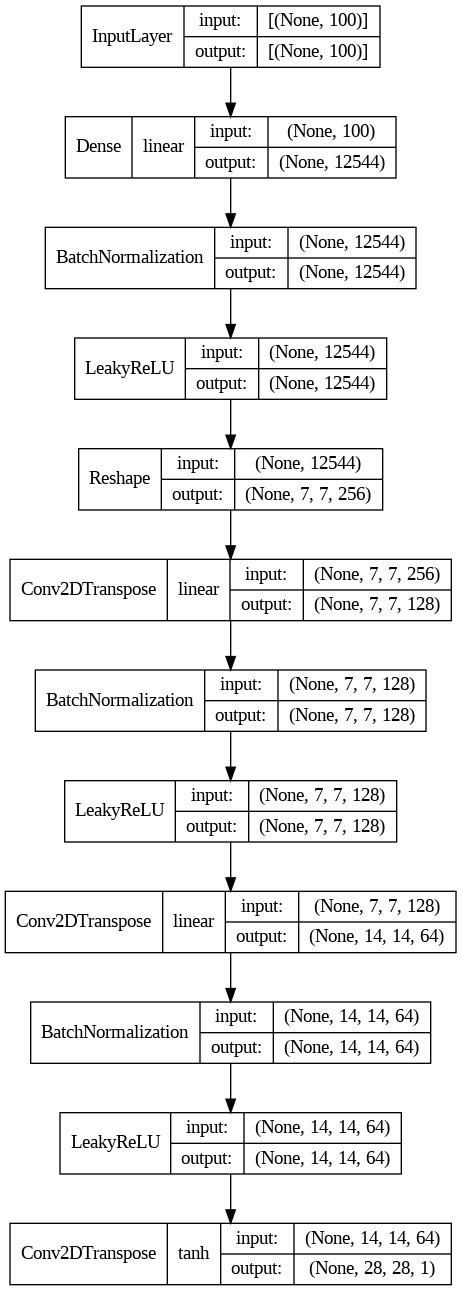

In [ ]:
generator = make_generator_model()
plot_model(generator,show_layer_activations=True,show_shapes=True,show_layer_names=False)

# 판별자 정의

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

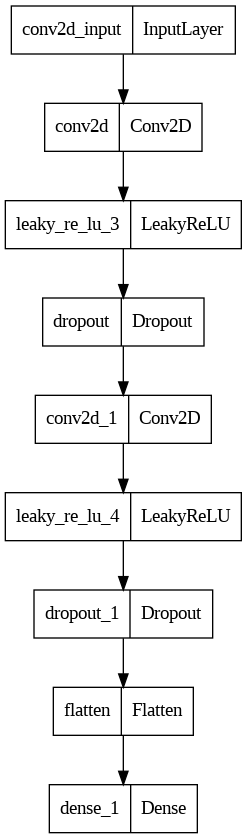

In [ ]:
discriminator = make_discriminator_model()
plot_model(discriminator)

## 생성자 판별자 초기상태 확인.

[]

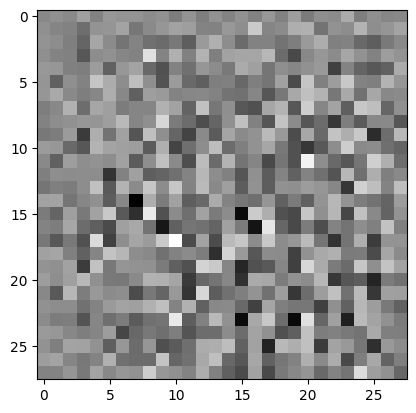

In [ ]:
# 생성자와 판별자의 초기상태를 확인합니다.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# 전혀 학습되지 않았을때 생성하는 이미지를 확인해봅니다.
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.plot()

In [ ]:
# 그 이미지가 진짜이미지인지 가짜이미지인지 판별하는 코드를 작성합니다.
# 진짜 이미지이면 양수
# 가짜 이미지이면 음수를 반환합니다.
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00278065]], shape=(1, 1), dtype=float32)


# GAN 모델 학습 꾸리기.

## 옵티마이저 정의

In [ ]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# 판별자가 가지는 loss를 정의합니다.
def discriminator_loss(real_output, fake_output):
    # 실제 이미지에 대한 디스크리미네이터의 출력을 평가합니다.
    # 디스크리미네이터가 실제 이미지를 '실제'로 올바르게 인식하는 경우에 손실이 감소하도록 합니다.
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # 가짜 (생성된) 이미지에 대한 디스크리미네이터의 출력을 평가합니다.
    # 디스크리미네이터가 가짜 이미지를 '가짜'로 올바르게 인식하는 경우에 손실이 감소하도록 합니다.
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # 실제 이미지와 가짜 이미지에 대한 손실을 합하여 전체 손실을 계산합니다.
    total_loss = real_loss + fake_loss

    return total_loss

In [ ]:
# 생성자의 loss 함수를 정의합니다.
def generator_loss(fake_output):
    # 가짜 (생성된) 이미지에 대한 디스크리미네이터의 출력을 평가합니다.
    # 생성기의 목표는 디스크리미네이터가 생성된 이미지를 '실제'로 인식하도록 만드는 것입니다.
    # 따라서 생성기는 디스크리미네이터의 출력이 1에 가깝게 되도록 학습됩니다.
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# 생성기에 대한 최적화 알고리즘 설정: Adam 최적화기를 사용하며 학습률은 1e-4입니다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 디스크리미네이터에 대한 최적화 알고리즘 설정: Adam 최적화기를 사용하며 학습률은 1e-4입니다.
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# 학습

In [ ]:
# 체크포인트를 저장합니다. 일반적으로 GAN 알고리즘은 매우 오래걸리기 때문에 체크포인트를 저장합니다.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 훈련하기

In [ ]:
EPOCHS = 60 # 학습횟스를 정의합니다.
noise_dim = 100
num_examples_to_generate = 16

# 시드를 생성합니다.
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# `tf.function` 데코레이터는 TensorFlow 그래프를 사용하여 함수를 최적화합니다.
# 이를 통해 실행 속도가 향상될 수 있습니다.
@tf.function
def train_step(images):
    # 무작위로 잡음 (noise) 벡터를 생성합니다. GAN의 생성기는 이 잡음 벡터를 사용하여 이미지를 생성합니다.
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # GradientTape는 자동 미분을 위해 연산을 기록합니다.
    # 여기서는 생성기와 디스크리미네이터의 그래디언트를 동시에 기록합니다.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 잡음을 사용하여 이미지를 생성합니다.
        generated_images = generator(noise, training=True)

        # 디스크리미네이터를 사용하여 실제 이미지와 생성된 이미지의 출력값을 얻습니다.
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 생성기와 디스크리미네이터의 손실을 계산합니다.
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # GradientTape를 사용하여 손실에 대한 생성기와 디스크리미네이터의 그래디언트를 계산합니다.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 계산된 그래디언트를 사용하여 생성기와 디스크리미네이터의 가중치를 업데이트합니다.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
def train(dataset, epochs):
    # 각 에포크별로 학습을 시작합니다.
    for epoch in range(epochs):
        # 현재 에포크의 시작 시간을 기록합니다.
        start = time.time()

        # 데이터셋의 각 배치에 대하여 학습 단계를 수행합니다.
        for image_batch in dataset:
            train_step(image_batch)

        # 학습 중간의 결과를 화면에 표시하기 위해 출력을 초기화합니다.
        display.clear_output(wait=True)

        # 현재 에포크의 결과로 이미지를 생성하고 저장합니다.
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # 15 에포크마다 모델의 체크포인트를 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # 현재 에포크의 학습에 걸린 시간을 출력합니다.
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # 모든 에포크의 학습이 완료된 후, 최종 결과로 이미지를 생성하고 저장합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
plt.show()

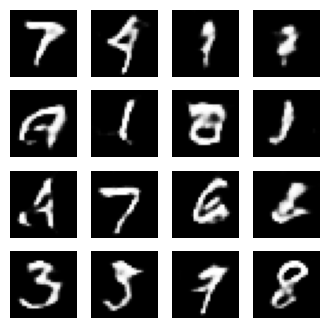

In [ ]:
with tf.device('/GPU:0'):
    # Your TensorFlow code goes here
    train(train_dataset, EPOCHS)